In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from visdom import Visdom

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
from torchsummary import summary

%matplotlib inline

In [2]:
image_size = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
)

test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
def view(z, color):
    tsne_z = TSNE(n_components=2).fit_transform(z)
    plt.figure(figsize=(6, 6))
    plt.scatter(tsne_z[:, 0], tsne_z[:, 1], color=color)
    plt.title('t-SNE')
    plt.xlabel('The first score')
    plt.ylabel('The second score')

    pca_z = PCA(n_components=2).fit_transform(z)
    plt.figure(figsize=(6, 6))
    plt.scatter(pca_z[:, 0], pca_z[:, 1], color=color)
    plt.title('PCA')
    plt.xlabel('The first principal component score')
    plt.ylabel('The second principal component score')

In [5]:
def result(cnn, detail=False, visualize=False):
    if detail:
        summary(cnn.features, (3, 224, 224))
    
    z = list()
    z_label = list()
    for i, (imgs, labels) in enumerate(test_loader):
            imgs = imgs.cuda()
            features = cnn.features(imgs).data.cpu().numpy()
        
            z.extend(features)
            z_label.extend(labels.numpy())
        
    z = np.array(z).reshape(153, -1).astype(torch.dtype)
    z_label = np.array(z_label, dtype=torch.dtype)
    
    feature_ae = pd.DataFrame({'label': z_label})
    
    feature_ae['type'] = feature_ae['label'].apply(lambda x: 'a' if x == 0 else 'h')
    color_code = {'a': '#FF0000', 'h': '#0000FF'}
    feature_ae['color'] = feature_ae['type'].apply(lambda x: color_code[x])
    
    if visualize:
        view(z, feature_ae['color'])
    
    kmeans = KMeans(n_clusters=2).fit(z)
    pred = kmeans.labels_

    count = [{'a': 0, 'h': 0} for _ in range(2)]
    for i, label in enumerate(pred):
        count[label][feature_ae['type'][i]] += 1
    print(cnn.__class__.__name__, count)

In [6]:
cnns = [
    models.alexnet(pretrained=True),
    models.vgg11(pretrained=True),
    models.vgg16(pretrained=True),
    #models.googlenet(pretrained=True),
    #models.resnet18(pretrained=True),
    #models.resnet50(pretrained=True)
]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

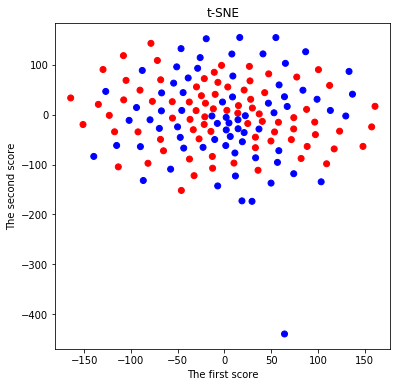

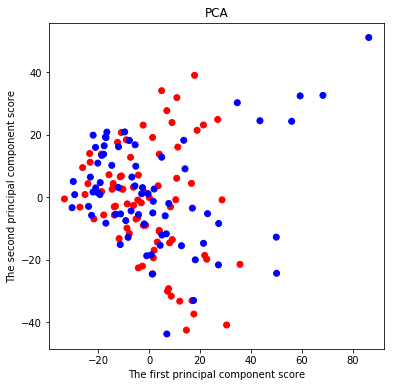

In [7]:
result(cnns[2].cuda(), visualize=True, detail=True)

In [8]:
class resnet_feature(nn.Module):
    def __init__(self):
        super(resnet_feature, self).__init__()
        self.features = nn.Sequential(
            *list(models.resnet18(pretrained=True).children())[:-1]
        )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

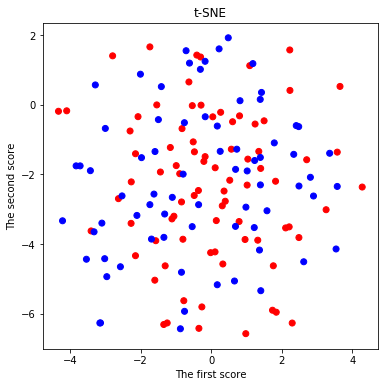

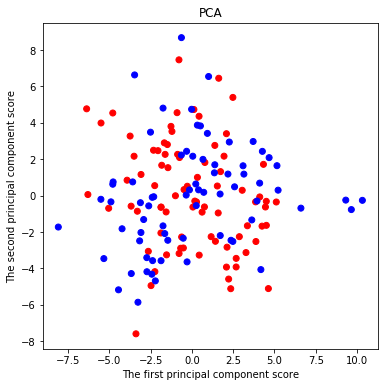

In [9]:
result(resnet_feature().cuda(), visualize=True, detail=True)